https://pubmed.ncbi.nlm.nih.gov/20369969/
Adams BM, Banks HT, Kwon HD, Tran HT. Dynamic multidrug therapies for hiv: optimal and sti control approaches. Math Biosci Eng. 2004 Sep;1(2):223-41. doi: 10.3934/mbe.2004.1.223. PMID: 20369969.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from hiv_patient import HIVPatient

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from collections import deque
from joblib import dump, load
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from IPython import display

import gym

%matplotlib inline

<ipython-input-1-ca3e21194a44>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Utils

In [2]:
def plot_reward(values, moving_avg_period):
    """Plots moving average on rewards and clean output """
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg", moving_avg[-1])
    display.clear_output(wait=True)
    
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [3]:
def plot_stuff(states, LOG_SCALE=True):
    """Plots biological stuff"""
    fig, axs = plt.subplots(2, 3, figsize=(15, 15))
    if LOG_SCALE:
        for ax in axs.ravel():
            ax.set_yscale('log')
    npst = np.array(states)
    axs[0,0].plot(npst[:,0])
    axs[0,0].set_title("T1")
    axs[0,1].plot(npst[:,1])
    axs[0,1].set_title("T1*")
    axs[0,2].plot(npst[:,2])
    axs[0,2].set_title("T2")
    axs[1,0].plot(npst[:,3])
    axs[1,0].set_title("T2*")
    axs[1,1].plot(npst[:,4])
    axs[1,1].set_title("V")
    axs[1,2].plot(npst[:,5])
    axs[1,2].set_title("E")
    plt.show()

In [4]:
def choose_action(state, policy, EPS=0.15, INIT=False, DISPLAY=False):
    """Epsilon-greedy action choice. 
    state: np.array or torch without all the stuff around
    policy: sklearn model, or pytorch model
    """
    if (np.random.random() > EPS) and not(INIT):
        all_Q = policy(state)
        if DISPLAY:
            print(all_Q)
        next_action = all_Q.argmax()
        return next_action
    else:
        return np.random.randint(0, N_ACTION)

In [5]:
class ReplayBuffer:
    def __init__(self, maxlen=60_000):
        super().__init__()
        self.maxlen = maxlen
        self.buffer = deque(maxlen=maxlen)
        
    def fill_buffer(self, env, nb_initial):
        """Fills the buffer with random actions"""
        s = env.reset()
        for i in tqdm(range(nb_initial), desc="Filling buffer"):    
            action = choose_action(s, None, INIT=True)
            new_s, r, d, _ = env.step(action)

            one_hot_action = np.zeros(N_ACTION)
            one_hot_action[action] = 1

            new_item = (s, one_hot_action, r, new_s, d)
            self.append(new_item)

            s = new_s
            
            if d:
                s = env.reset()
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def append(self, new_item):
        self.buffer.append(new_item)
        
    def drop(self):
        """Empty the deque"""
        self.buffer = deque(maxlen=self.maxlen)
        
    def __repr__(self):
        return f"<ReplayBuffer : {len(self.buffer)} items>"
    
    def __len__(self):
        return len(self.buffer)
    

In [45]:
def make_simulation(s):
    """Makes simulation for FQI"""
    s[5] *= .75
    env.E *= .75
    print(env.E)
    dur = 400 # 400/5
    states = [s]
    rewards = [0]

    for i in tqdm(range(dur)):
        action = choose_action(s, best_hqi, INIT=False, EPS=0, DISPLAY=False)
#         print(action, end=' ')
        s, r, d, _ = env.step(action)
        rewards.append(r)
        states.append(s)

    print()
    print(80*sum(rewards)/dur)
    return states, rewards


def make_simulation_dqn(s, model, dur=200):
    """Makes simulation for DQN"""
    s[5] *= .75
    env.E *= .75
    print(env.E)
    states = [s]
    rewards = [0]

    for i in tqdm(range(dur)):
        s = torch.Tensor(s).unsqueeze(0)
        action = choose_action(s, model, INIT=False, EPS=0, DISPLAY=False)
        print(action.item(), end=' ')
        s, r, d, _ = env.step(action)
        rewards.append(r)
        states.append(s)
    
    return states

# Fitted Q-iteration

In [8]:
# env = gym.make('CartPole-v1')
# N_ACTION = env.action_space.n
# DIM_STATE = env.observation_space.shape[0]
# env.reset()

In [9]:
env = HIVPatient(clipping=False, logscale=False)
N_ACTION = len(env.action_set)
DIM_STATE = len(env.state())
INIT_STATES = ['healthy', 'unhealthy', "uninfected"]
env.reset()

array([1.63573e+05, 1.19450e+04, 5.00000e+00, 4.60000e+01, 6.39190e+04,
       2.40000e+01])

In [10]:
class HQIAgent:
    def __init__(self):
        super().__init__()
        self.model = RandomForestRegressor()
        self.gamma = 0.98
        
        
    def train(self, replay_buffer, INIT=False):
        """Fits the model on the total buffer"""
        
        len_buffer = len(replay_buffer)
        buffer = replay_buffer.sample(len_buffer)
        print(f"----- Training on {len_buffer} samples")

        X = np.zeros((len_buffer, N_ACTION + DIM_STATE))
        y = np.zeros((len_buffer))

        x_ = np.zeros((len_buffer, DIM_STATE)) # next states
        r = np.zeros((len_buffer, 1))

        for i, item in enumerate(buffer):
            X[i] = np.concatenate([item[0], item[1]])
            x_[i] = item[3]
            r[i] = item[2]

        if INIT:
            maxQ = np.zeros((len_buffer, 1))
        else:
            # xa = [[state@action1], [state@action2] ...] de dimension (len_buffer, 10)
            xa = np.zeros((len_buffer * N_ACTION, N_ACTION + DIM_STATE))
            xa[:, :DIM_STATE] = np.repeat(x_, N_ACTION, axis=0)
            xa[:, DIM_STATE:] = np.tile(np.eye(N_ACTION), reps=(len_buffer, 1))

            # all_Q = [Q(state, action1), Q(state, action2)] de dimension (len_buffer, 1)
            all_Q = self.model.predict(xa)
            all_Q = all_Q.reshape((len_buffer, -1))

            maxQ = np.max(all_Q, axis=1).reshape(len_buffer, 1)
            
        
        y = (r + self.gamma * maxQ).ravel()
        
        self.model.fit(X, y)

        
    def predict(self, state):
        xa = [np.concatenate((state, a)) for a in np.eye(N_ACTION)]
        all_Q = self.model.predict(xa)
        return all_Q
        
        
    def __call__(self, state):
        return self.predict(state)
    
    
    def save(self, filename='model.hqi'):
        dump(self.model, filename) 
    
    
    def load(self, filename='model.hqi'):
        self.model = load(filename) 
        print(f"Model loaded from {filename}")

In [11]:
duration = 80
nb_patients = 30
patients = [HIVPatient(clipping=False, logscale=False) for _ in range(nb_patients)]

def get_performance_model(hqi_agent): 
    """Valid the model on one patient (or multiple ones if INIT_STATES contains the init states)"""
    env = patients[0]
    rew_by_state = []
    for init_state in INIT_STATES:
        s = env.reset(init_state)
        sum_reward = 0
        for t in tqdm(range(duration), desc=f"[Valid]", leave=False):
            action = choose_action(s, hqi_agent, INIT=False, EPS=0)
            new_s, r, d, _ = env.step(action)
            sum_reward += r
            s = new_s
        rew_by_state.append(sum_reward)
    return rew_by_state, np.mean(rew_by_state)

In [12]:
def explore_space(hqi_agent, replay_buffer, INIT=False):
    """Explores epsilon-greedily the space to fill the buffer for all the patients"""
    for i_patient in range(nb_patients):
        env = patients[i_patient]
        init_state = random.choice(INIT_STATES)
        s = env.reset(init_state)
        for t in tqdm(range(duration), desc=f"[Explore] Patient {init_state} {i_patient}", leave=False):
            action = choose_action(s, hqi_agent, INIT=INIT)
            new_s, r, d, _ = env.step(action)
            
            # Fill replay buffer
            one_hot_action = np.zeros(N_ACTION)
            one_hot_action[action] = 1
            new_item = (s, one_hot_action, r, new_s)
            replay_buffer.append(new_item)
            s = new_s

In [11]:
nb_initial = 1000
replay_buffer = ReplayBuffer()
# replay_buffer.fill_buffer(env, nb_initial)

## Main training loop

In [ ]:
import copy

nb_iteration = 20
hqi_agent = HQIAgent()
best_hqi = None
best_mean_reward = 0

for iteration in range(nb_iteration):
    try:
        INIT = (iteration == 0)
        explore_space(hqi_agent, replay_buffer, INIT=INIT)
        hqi_agent.train(replay_buffer, INIT=INIT)
        rew_by_state, mean_reward = get_performance_model(hqi_agent)
        if mean_reward > best_mean_reward:
            best_hqi = copy.deepcopy(hqi_agent)
            best_mean_reward = mean_reward
            print(f"({iteration}) Save model !")
        print(rew_by_state, mean_reward)
    except KeyboardInterrupt:
        print("Ended !")

In [ ]:
dump(best_hqi.model, "2103.hqi") 

## Test

In [ ]:
# # Cartpole
# x = env.reset()
# env.render()
# for i in range(1000):
#     a = choose_action(x, hqi_agent, INIT=False, EPS=0, DISPLAY=True)
#     print(a)
#     y, _, d, _ = env.step(a)
#     env.render()
#     x = y
#     if d:
#         print(i)
#         break

# env.close()

In [ ]:
s = env.reset('unhealthy')
states_unhealthy, rew = make_simulation(s)
plot_stuff(states_unhealthy)

## Results

In [13]:
best_hqi = HQIAgent()
best_hqi.load('best_100iter_30patients.hqi') # Only trained on unhealthy patients
# best_hqi.load('best_multipurpose.hqi') # trained with all three INIT_STATES

C:\Users\Dinh-Viet-Toan\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded from best_100iter_30patients.hqi


C:\Users\Dinh-Viet-Toan\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


18.0


  0%|          | 0/400 [00:00<?, ?it/s]


5561059408.264941


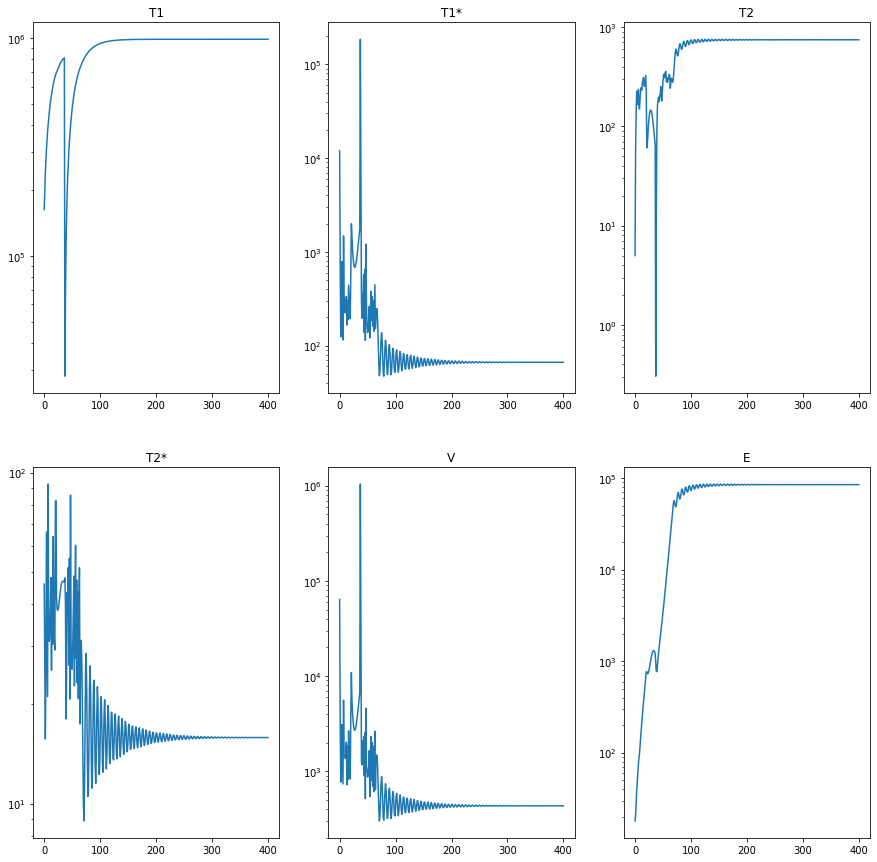

In [14]:
s = env.reset('unhealthy')
states_unhealthy, rew = make_simulation(s)
plot_stuff(states_unhealthy)

264831.0


  0%|          | 0/400 [00:00<?, ?it/s]


6181203144.453453


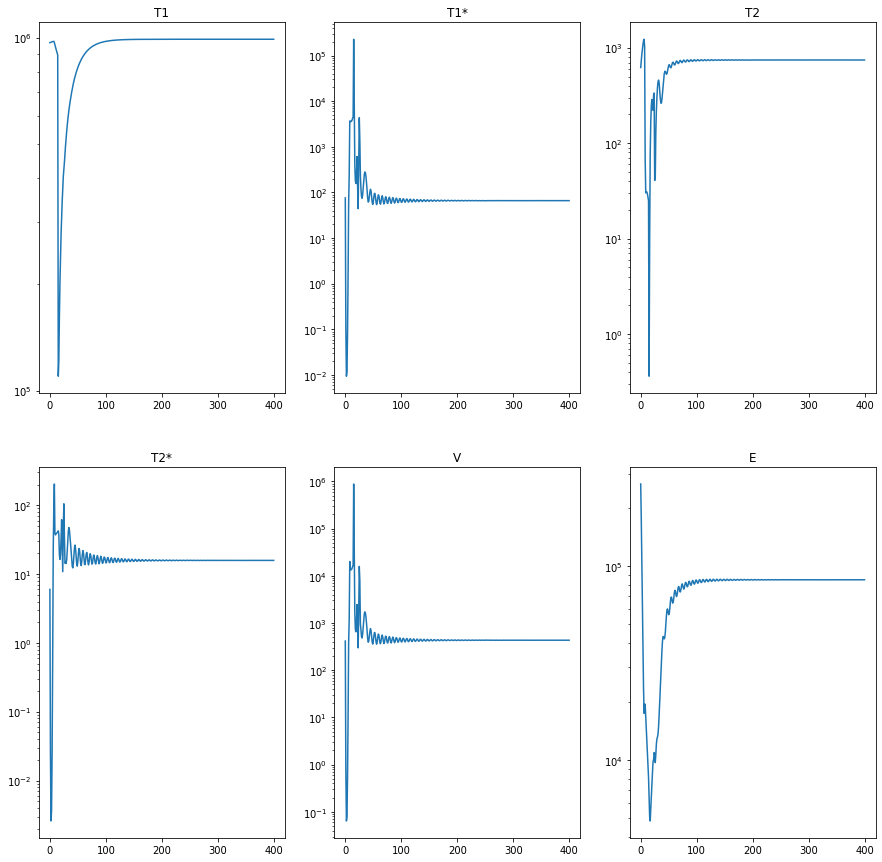

In [15]:
s = env.reset('healthy')
states_healthy, rew = make_simulation(s)
plot_stuff(states_healthy)

7.5


  0%|          | 0/400 [00:00<?, ?it/s]


798729.106015413


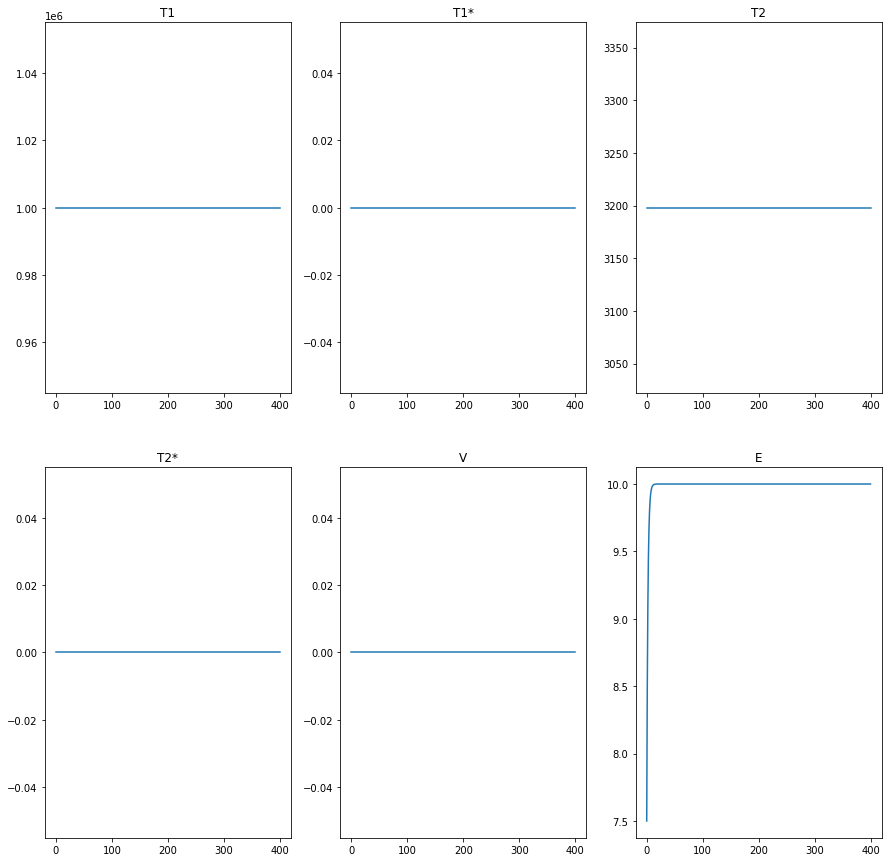

In [18]:
s = env.reset('uninfected')
states_uninfected, rew = make_simulation(s)
plot_stuff(states_uninfected, LOG_SCALE=False)

# DQN

In [55]:
# env = gym.make('CartPole-v1')
# N_ACTION = env.action_space.n
# DIM_STATE = env.observation_space.shape[0]
# env.reset()

In [60]:
env = HIVPatient(clipping=False, logscale=False)
N_ACTION = len(env.action_set)
DIM_STATE = len(env.state())
env.reset()

array([1.63573e+05, 1.19450e+04, 5.00000e+00, 4.60000e+01, 6.39190e+04,
       2.40000e+01])

In [61]:
class DenseNet(nn.Module):
    # Rq : ici, on donne l'état en entrée, et pour toutes les actions, son Q correspondant, contrairement au RF
    def __init__(self, IN_DIM=DIM_STATE, OUT_DIM=N_ACTION):
        super().__init__()
        self.fc1 = nn.Linear(IN_DIM, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, OUT_DIM)
        
    def forward(self, x):
        batch_size = x.shape[0]
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [34]:
class DQN_agent:
    def __init__(self, config, model):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'])
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max - self.epsilon_min) / self.epsilon_stop
        self.nb_gradient_steps = config['gradient_steps']
        self.total_steps = 0
        self.model = model 
        self.best_model = None
        
        self.target_model = copy.deepcopy(self.model).to(device) 
        self.update_target_freq = config['update_target_freq']
        
        self.criterion = torch.nn.MSELoss() # torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        self.reset_every = config['reset_every']
        self.plot = config['plot']
        
        self.target_model.eval()
    
    
    def make_training_data(self):
        """Splits a sample of the buffer in multiple tensors"""
        batch = self.memory.sample(self.batch_size)
        X, A, R, Y, D = [], [], [], [], []
        for sample in batch:
            X.append(sample[0])
            A.append(sample[1])
            R.append(sample[2])
            Y.append(sample[3])
            D.append(sample[4])
            
        return torch.Tensor(X), torch.Tensor(A), torch.Tensor(R), torch.Tensor(Y), torch.Tensor(D)
    
    
    def print_grads(self):
        """Displays the gradients max and min"""
        print(
            "fc3 : [{:.2e}, {:.2e}] ; fc2 : [{:.2e}, {:.2e}] ; fc1 : [{:.2e}, {:.2e}]".format(
                torch.min(self.model.fc3.weight.grad).item(),
                torch.max(self.model.fc3.weight.grad).item(),
                torch.min(self.model.fc2.weight.grad).item(),
                torch.max(self.model.fc2.weight.grad).item(),
                torch.min(self.model.fc1.weight.grad).item(),
                torch.max(self.model.fc1.weight.grad).item(),
            )
        )
        
    
    def gradient_step(self):
        running_loss = 0
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.make_training_data()
            X, A, R, Y, D = X.to(device), A.to(device), R.to(device), Y.to(device), D.to(device)
            QYmax = self.target_model(Y).max(1)[0].detach()
            update = torch.addcmul(R, self.gamma, 1-D, QYmax) # update = R + gamma * (1-D) * QYmax
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            
            running_loss += loss.item()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)
            self.optimizer.step() 
        
        return running_loss
    
    
    def train(self, env, max_episode):
        episode_return = []
        loss_return = []
        episode = 0
        episode_cum_reward = 0
        state = env.reset()
        epsilon = self.epsilon_max
        step = 0
        best_reward = 0
        
        
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)
#             epsilon = 0.15

            # select epsilon-greedy action
            action = choose_action(
                torch.Tensor(state).unsqueeze(0).to(device), 
                self.model, EPS=epsilon)
            
            if isinstance(action, torch.Tensor): action = action.item()
  
            # step
            next_state, reward, done, _ = env.step(action)
            new_item = (state, action, reward, next_state, done)
            self.memory.append(new_item)
            episode_cum_reward += reward

            # train
            running_loss = 0
            for _ in range(self.nb_gradient_steps):
                running_loss += self.gradient_step()
                
            
            # update target
            if step % self.update_target_freq == 0:
                print("Updating target")
                self.target_model.load_state_dict(self.model.state_dict())

            # next transition
            step += 1
            
            done = done or (step % self.reset_every == 0)
            
            # display stuff
            if done:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", step ", '{:6d}'.format(step), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", memory size ", '{:5d}'.format(len(self.memory)), 
                      ", loss ", '{:.2e}'.format(running_loss), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                
                if len(self.memory) > self.batch_size: self.print_grads()
                
                if episode_cum_reward > best_reward:
                    self.best_model = copy.deepcopy(self.model)
                    best_reward = episode_cum_reward
                    print("\033[1m\033[91m >>>>>> Best model update \033[0m\033[0m")
                    
                state = env.reset()
                episode_return.append(episode_cum_reward)
                loss_return.append(running_loss)
                
                running_loss = 0
                episode_cum_reward = 0
                
                print("===================================================")
                if self.plot:
                    plot_reward(episode_return, 20)
            else:
                state = next_state

        return episode_return, loss_return

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
DQN = DenseNet().to(device)

Using cpu


## Main training loop

Updating target
Episode   1, step     80, epsilon   0.97, memory size    80, loss 0.00e+00, episode return 3292634.1
 >>>>>> Best model update 
Episode   2, step    160, epsilon   0.94, memory size   160, loss 3.52e+09, episode return 3347707.7
fc3 : [-2.25e-01, 1.63e-02] ; fc2 : [-1.13e-01, 7.95e-02] ; fc1 : [-2.06e-01, 1.23e-01]
 >>>>>> Best model update 
Episode   3, step    240, epsilon   0.91, memory size   240, loss 4.26e+09, episode return 4075089.7
fc3 : [-2.90e-01, 1.54e-01] ; fc2 : [-7.38e-02, 1.05e-01] ; fc1 : [-1.29e-01, 9.24e-02]
 >>>>>> Best model update 
Episode   4, step    320, epsilon   0.87, memory size   320, loss 4.28e+09, episode return 3165156.6
fc3 : [-7.99e-02, 2.83e-01] ; fc2 : [-1.15e-01, 1.34e-01] ; fc1 : [-2.29e-01, 1.77e-01]
Episode   5, step    400, epsilon   0.84, memory size   400, loss 4.14e+09, episode return 2189974.3
fc3 : [-2.02e-01, 2.32e-01] ; fc2 : [-1.78e-01, 1.13e-01] ; fc1 : [-9.39e-02, 1.04e-01]
Episode   6, step    480, epsilon   0.80, memo

Episode  34, step   2720, epsilon   0.15, memory size  2720, loss 2.16e+10, episode return 11691834.5
fc3 : [-3.39e-03, 6.60e-04] ; fc2 : [-1.45e-02, 9.21e-03] ; fc1 : [-4.31e-01, 5.68e-01]
Episode  35, step   2800, epsilon   0.15, memory size  2800, loss 2.37e+10, episode return 1809755.7
fc3 : [-1.71e-03, 1.62e-04] ; fc2 : [-1.45e-02, 8.45e-03] ; fc1 : [-4.37e-01, 5.74e-01]
Episode  36, step   2880, epsilon   0.15, memory size  2880, loss 2.15e+10, episode return 13851120.8
fc3 : [0.00e+00, 1.55e-03] ; fc2 : [-6.89e-03, 1.35e-02] ; fc1 : [-5.36e-01, 4.21e-01]
Episode  37, step   2960, epsilon   0.15, memory size  2960, loss 1.70e+10, episode return 3267380.2
fc3 : [-2.43e-03, 5.02e-04] ; fc2 : [-1.42e-02, 8.38e-03] ; fc1 : [-4.35e-01, 5.75e-01]
Episode  38, step   3040, epsilon   0.15, memory size  3040, loss 1.85e+10, episode return 7476219.6
fc3 : [-1.37e-04, 2.36e-03] ; fc2 : [-7.69e-03, 1.35e-02] ; fc1 : [-5.63e-01, 4.29e-01]
Episode  39, step   3120, epsilon   0.15, memory size 

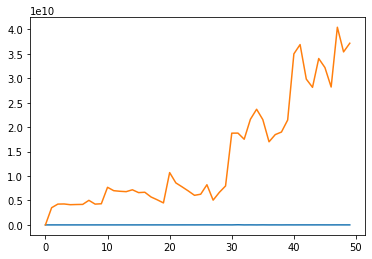

In [38]:
config = {'observation_space': DIM_STATE,
          'nb_actions': N_ACTION,
          'learning_rate': 0.001,
          'gamma': 0.99,
          'buffer_size': 60_000,
          'epsilon_max': 1.,
          'epsilon_delay_decay': 20,
          'update_target_freq': 80*10,
       
#          # --- HIV
          'epsilon_min': 0.15,
          'epsilon_decay_period': 2000,
          'gradient_steps': 10,
          'batch_size': 128,
          'reset_every': 80,
          'plot': False,
          
#          # --- CartPole
#           'epsilon_min': 0.01,
#           'epsilon_decay_period': 1000,
#           'gradient_steps': 1,
#           'batch_size': 32,
#           'reset_every': 1000000,
#           'plot' : False
}

agent = DQN_agent(config, DQN)
scores, losses = agent.train(env, 50)
plt.plot(scores)
plt.plot(losses)

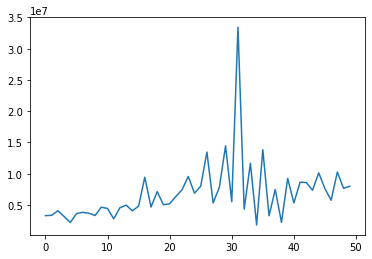

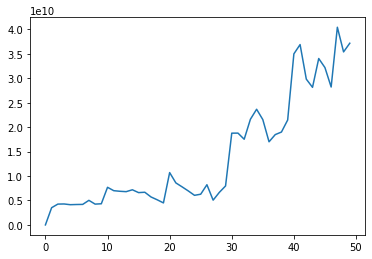

In [65]:
plt.plot(scores); plt.show()
plt.plot(losses); plt.show()

## Test

In [39]:
# # Cartpole
# x = env.reset()
# env.render()
# for i in range(1000):
#     x = torch.Tensor(x)
#     a = choose_action(x, agent.best_model, INIT=False, EPS=0, DISPLAY=False).item()
#     y, _, d, _ = env.step(a)
#     env.render()
#     x = y
#     if d: 
#         break
# env.close()

In [ ]:
s = env.reset('unhealthy') # 'uninfected', 'healthy'
states = make_simulation_dqn(s, agent.best_model)
plot_stuff(states)

## Results

**Avec target, loss MSE, clip=1, hidden_layers=5, hidden_size=64, decay_eps=2000, 100/200 episodes**

(Vanishing gradient à la fin de l'entrainement en revanche)

In [50]:
class DenseNet(nn.Module):
    def __init__(self, IN_DIM=DIM_STATE, OUT_DIM=N_ACTION):
        super().__init__()
        self.fc1 = nn.Linear(IN_DIM, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, OUT_DIM)
        
    def forward(self, x):
        batch_size = x.shape[0]
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        return out
    
model = DenseNet()
# model.load_state_dict(torch.load('model_clip_fc5_64.dqn', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('model_clip_fc5_64_200ep.dqn', map_location=torch.device('cpu')))

<All keys matched successfully>

18.0


  0%|          | 0/300 [00:00<?, ?it/s]

2 2 3 2 2 2 1 2 2 2 2 3 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 0 0 3 3 0 0 2 1 2 2 2 1 3 3 3 2 2 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 0 0 3 3 0 0 0 0 3 3 0 3 3 0 3 3 3 3 0 3 3 3 3 3 2 2 3 0 3 3 3 0 3 3 0 3 3 3 0 3 3 3 3 3 2 2 2 3 3 0 3 3 3 0 3 0 3 3 0 3 3 3 0 3 3 3 3 2 0 3 3 3 3 3 2 2 2 3 2 3 3 0 3 3 3 0 3 0 3 3 3 0 3 3 3 3 0 3 3 3 3 3 2 2 2 3 0 3 3 3 0 3 0 3 3 0 3 3 3 3 0 3 3 3 3 3 2 2 3 0 3 3 3 0 3 3 0 3 3 3 0 3 3 3 3 3 2 2 0 3 3 3 0 3 3 0 3 3 3 0 3 3 3 3 3 2 2 3 0 3 3 3 0 3 3 0 3 3 3 0 3 3 3 3 3 2 2 2 3 3 0 3 3 3 0 3 0 3 3 0 3 3 3 0 3 3 3 3 0 3 3 3 3 3 0 3 3 3 3 3 2 2 3 0 3 3 3 0 3 3 0 3 3 3 0 3 3 3 

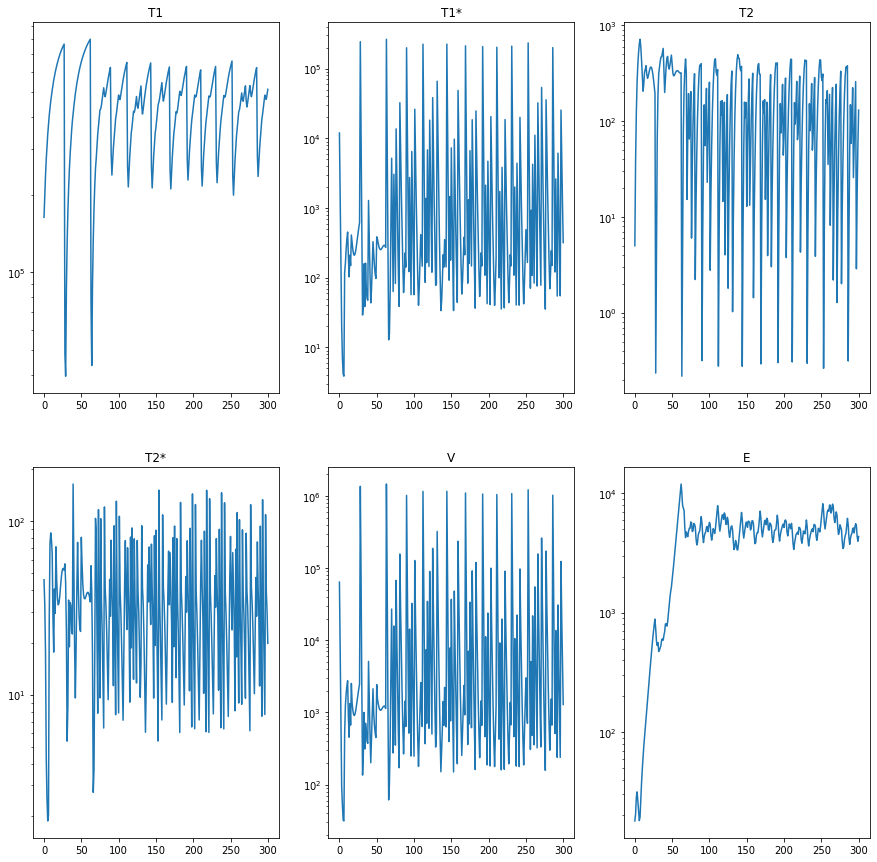

In [51]:
s = env.reset('unhealthy') # 'uninfected', 'healthy'
states = make_simulation_dqn(s, model, dur=300)

plot_stuff(states)

**Avec target, loss MSE, clip, hidden64, layers3, 1000 episodes**

In [23]:
class DenseNet(nn.Module):
    def __init__(self, IN_DIM=DIM_STATE, OUT_DIM=N_ACTION):
        super().__init__()
        self.fc1 = nn.Linear(IN_DIM, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, OUT_DIM)
        
    def forward(self, x):
        batch_size = x.shape[0]
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
model = DenseNet()
model.load_state_dict(torch.load('model_clip_hidden64.dqn'))

<All keys matched successfully>

18.0


  0%|          | 0/200 [00:00<?, ?it/s]

2 3 3 3 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 

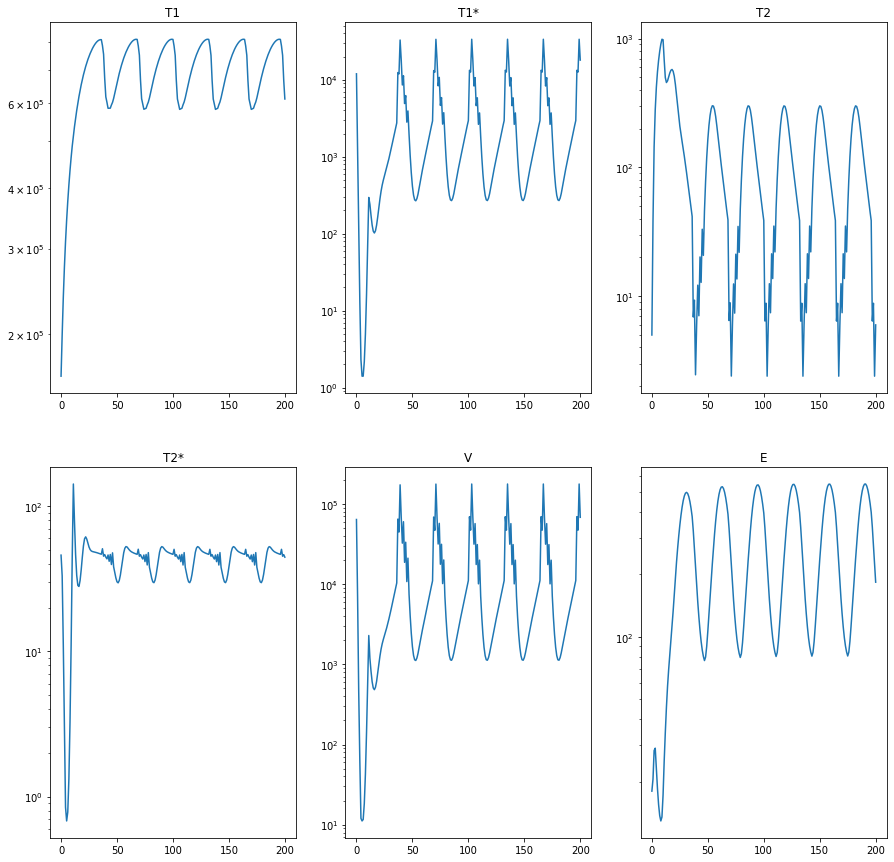

In [24]:
s = env.reset('unhealthy') # 'uninfected', 'healthy'
states = make_simulation_dqn(s, model)

plot_stuff(states)

**Avec target, loss MSE, sans clip, hidden24**

In [25]:
class DenseNet(nn.Module):
    def __init__(self, IN_DIM=DIM_STATE, OUT_DIM=N_ACTION):
        super().__init__()
        self.fc1 = nn.Linear(IN_DIM, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, OUT_DIM)
        
    def forward(self, x):
        batch_size = x.shape[0]
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
model = DenseNet()
model.load_state_dict(torch.load('model_clip_mse.dqn', map_location=torch.device('cpu')))

<All keys matched successfully>

18.0


  0%|          | 0/200 [00:00<?, ?it/s]

2 3 3 3 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

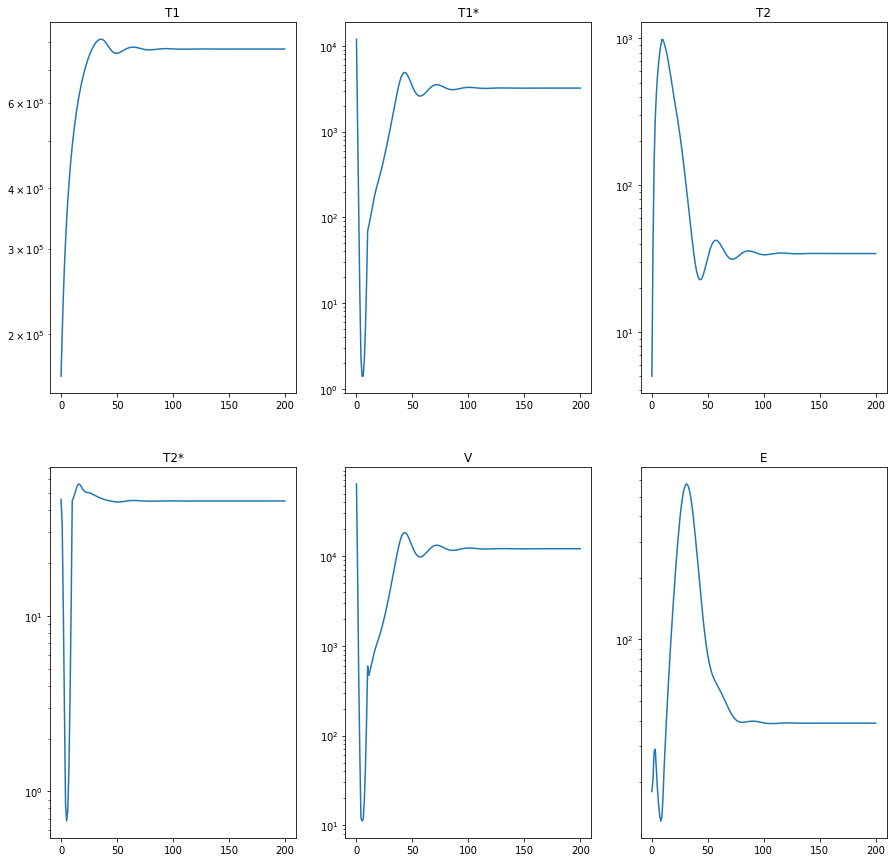

In [26]:
s = env.reset('unhealthy') # 'uninfected', 'healthy'
states = make_simulation_dqn(s, model)

plot_stuff(states)